In [88]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [89]:
def preprocess_data(data):
    data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: -1 if x == 0 else 1)
    
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

In [90]:
train_path = 'bank-note/train.csv' 
test_path = 'bank-note/test.csv'
train_data = pd.read_csv(train_path, header=None)
test_data = pd.read_csv(test_path, header=None)
X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

In [91]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path, header=None)
    test_data = pd.read_csv(test_path, header=None)
    return train_data, test_data

In [92]:
def hinge_loss(w, X, y, C):
    return np.sum(np.maximum(0, 1 - y * np.dot(X, w))) / len(X) + C * np.linalg.norm(w)**2

In [93]:
def sgd_svm(train_data, test_data, C, gamma_0, a, T=100):
    X_train, y_train = preprocess_data(train_data)
    X_test, y_test = preprocess_data(test_data)

    w = np.zeros(X_train.shape[1])
    n = len(X_train)
    objective_values = []

    for epoch in range(T):
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(n):
            gamma_t = gamma_0 / (1 + gamma_0 / a * (epoch * n + i))
            if y_train[i] * np.dot(X_train[i], w) < 1:
                w = w - gamma_t * (-y_train[i] * X_train[i] + 2 * C * w)
            else:
                w = w - gamma_t * (2 * C * w)

        objective_values.append(hinge_loss(w, X_train, y_train, C))

    train_predictions = np.sign(np.dot(X_train, w))
    test_predictions = np.sign(np.dot(X_test, w))
    train_error = np.mean(train_predictions != y_train)
    test_error = np.mean(test_predictions != y_test)

    return w, objective_values, train_error, test_error

## Problem  2A

C=0.1145475372279496: Train Error = 0.10321100917431193, Test Error = 0.114
C=0.572737686139748: Train Error = 0.13302752293577982, Test Error = 0.124
C=0.8018327605956472: Train Error = 0.13302752293577982, Test Error = 0.126


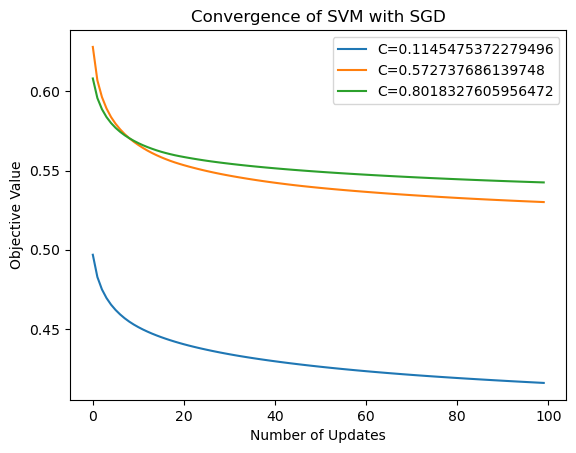

In [94]:
train_path = 'bank-note/train.csv'
test_path = 'bank-note/test.csv'  
C_values = [100/873, 500/873, 700/873]
gamma_0 = 0.01
a = 0.01   

train_data, test_data = load_data(train_path, test_path)

for C in C_values:
    w, objective_values, train_error, test_error = sgd_svm(train_data, test_data, C, gamma_0, a)
    print(f"C={C}: Train Error = {train_error}, Test Error = {test_error}")

    plt.plot(objective_values, label=f'C={C}')

plt.xlabel('Number of Updates')
plt.ylabel('Objective Value')
plt.title('Convergence of SVM with SGD')
plt.legend()
plt.show()

In [95]:
# Modified Stochastic Sub-Gradient Descent for SVM with new learning rate schedule
def sgd_svm_new_schedule(train_data, test_data, C, gamma_0, T=100):
    X_train, y_train = preprocess_data(train_data)
    X_test, y_test = preprocess_data(test_data)

    w = np.zeros(X_train.shape[1])
    n = len(X_train)
    
    objective_values = []

    for epoch in range(T):
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(n):
            gamma_t = gamma_0 / (1 + i)
            if y_train[i] * np.dot(X_train[i], w) < 1:
                w = w - gamma_t * (-y_train[i] * X_train[i] + 2 * C * w)
            else:
                w = w - gamma_t * (2 * C * w)

        objective_values.append(hinge_loss(w, X_train, y_train, C))

    train_predictions = np.sign(np.dot(X_train, w))
    test_predictions = np.sign(np.dot(X_test, w))
    
    train_error = np.mean(train_predictions != y_train)
    test_error = np.mean(test_predictions != y_test)

    return w, objective_values, train_error, test_error

## Problem 2B

C=0.1145475372279496: Train Error = 0.12155963302752294, Test Error = 0.104
C=0.572737686139748: Train Error = 0.1559633027522936, Test Error = 0.136
C=0.8018327605956472: Train Error = 0.16055045871559634, Test Error = 0.14


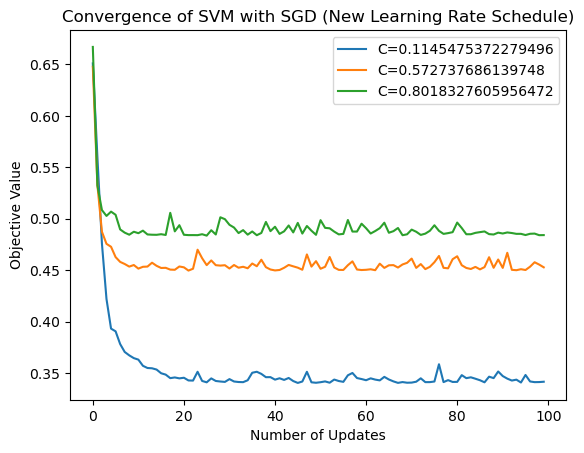

In [96]:
gamma_0_new = 0.01  # Example value, needs tuning

for C in C_values:
    w, objective_values, train_error, test_error = sgd_svm_new_schedule(train_data, test_data, C, gamma_0_new)
    print(f"C={C}: Train Error = {train_error}, Test Error = {test_error}")

    plt.plot(objective_values, label=f'C={C}')

plt.xlabel('Number of Updates')
plt.ylabel('Objective Value')
plt.title('Convergence of SVM with SGD (New Learning Rate Schedule)')
plt.legend()
plt.show()


In [97]:
def compare_svm_schedules(train_data, test_data, C_values, gamma_0, a, gamma_0_new, T=100):
    comparison_results = []

    for C in C_values:
        w1, _, train_error1, test_error1 = sgd_svm(train_data, test_data, C, gamma_0, a)

        w2, _, train_error2, test_error2 = sgd_svm_new_schedule(train_data, test_data, C, gamma_0_new)

        param_diff = np.linalg.norm(w1 - w2)
        train_error_diff = abs(train_error1 - train_error2)
        test_error_diff = abs(test_error1 - test_error2)

        comparison_results.append((C, param_diff, train_error_diff, test_error_diff))

    return comparison_results

## Problem 2C

In [98]:
comparison_results = compare_svm_schedules(train_data, test_data, C_values, gamma_0, a, gamma_0_new)

for C, param_diff, train_error_diff, test_error_diff in comparison_results:
    print(f"C={C}:")
    print(f"  Parameter Difference: {param_diff}")
    print(f"  Train Error Difference: {train_error_diff}")
    print(f"  Test Error Difference: {test_error_diff}\n")

C=0.1145475372279496:
  Parameter Difference: 0.4456368229651788
  Train Error Difference: 0.03784403669724769
  Test Error Difference: 0.036000000000000004

C=0.572737686139748:
  Parameter Difference: 0.24736501706855468
  Train Error Difference: 0.05275229357798164
  Test Error Difference: 0.04600000000000001

C=0.8018327605956472:
  Parameter Difference: 0.20972091111942961
  Train Error Difference: 0.042431192660550454
  Test Error Difference: 0.04200000000000001


In [99]:
def svm_dual_objective_optimized_v2(alpha, K):
    return 0.5 * np.dot(alpha, np.dot(K, alpha)) - np.sum(alpha)

In [100]:
def svm_dual_constraint(alpha, y):
    return np.dot(alpha, y)

In [101]:
def svm_dual_v2(X, y, C):
    K = np.outer(y, y) * np.dot(X, X.T)  # Linear kernel - consider non-linear kernels if needed
    n = len(y)
    alpha_init = np.random.uniform(low=0.0, high=0.1, size=n)  # Changed to small random values

    bounds = [(0, C) for _ in range(n)]
    constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)}

    result = minimize(svm_dual_objective_optimized_v2, alpha_init, args=(K,), method='SLSQP', bounds=bounds, constraints=constraints)

    if not result.success:
        print(f"Optimization failed for C={C}: {result.message}")
        return None, None

    alpha = result.x
    w = np.dot((alpha * y), X)
    support_vectors_idx = np.where(alpha > 1e-5)[0]
    if len(support_vectors_idx) == 0:
        print("No support vectors found. Check data or hyperparameters.")
        return None, None
    b = np.mean(y[support_vectors_idx] - np.dot(X[support_vectors_idx], w))
    return w, b

## Problem 3A

In [102]:
# Example usage
for C in C_values:
    w_dual_optimized_v2, b_dual_optimized_v2 = svm_dual_v2(X_train, y_train, C)
    if w_dual_optimized_v2 is not None:
        print(f"C={C}: Weights (Dual Optimized) = {w_dual_optimized_v2}, Bias (Dual Optimized) = {b_dual_optimized_v2}")
    else:
        print(f"C={C}: Optimization failed or no support vectors found.")

/Users/jamesgibb/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


C=0.1145475372279496: Weights (Dual Optimized) = [-0.9423594  -0.65150238 -0.73407799 -0.04093477], Bias (Dual Optimized) = 1.0752680156451164
C=0.572737686139748: Weights (Dual Optimized) = [-1.56497747 -1.0131952  -1.18045085 -0.15630233], Bias (Dual Optimized) = 1.5131404220147286
C=0.8018327605956472: Weights (Dual Optimized) = [-2.04281324 -1.28004561 -1.51374958 -0.2485333 ], Bias (Dual Optimized) = 1.8810057421984707


## Problem 3B

In [103]:
def gaussian_kernel(X1, X2, gamma):
    
    X1_sq = np.sum(X1**2, axis=1)
    X2_sq = np.sum(X2**2, axis=1)
    sq_dists = -2 * np.dot(X1, X2.T) + X1_sq[:, np.newaxis] + X2_sq
    return np.exp(-sq_dists / (2 * gamma**2))

def svm_dual_gaussian(X, y, C, gamma):
    K = gaussian_kernel(X, X, gamma)
    n = len(y)
    alpha_init = np.zeros(n)
    bounds = [(0, C) for _ in range(n)]
    
    constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)}
    result = minimize(lambda alpha: 0.5 * np.dot(alpha, np.dot(K, alpha)) - np.sum(alpha), alpha_init,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        print(f"Optimization failed for C={C}, gamma={gamma}")
        
    return result.x

def svm_predict_gaussian(X_train, y_train, X_test, alpha, gamma):
    
    K = gaussian_kernel(X_train, X_test, gamma)
    return np.sign(np.dot(K.T, alpha * y_train))

X_train, y_train = preprocess_data(pd.read_csv('bank-note/train.csv', header=None))
X_test, y_test = preprocess_data(pd.read_csv('bank-note/test.csv', header=None))

gamma_values = [0.1, 0.5, 1, 5, 100]
C_values = [100/873, 500/873, 700/873]

results = []

for gamma in gamma_values:
    for C in C_values:
        alpha = svm_dual_gaussian(X_train, y_train, C, gamma)
        
        train_predictions = svm_predict_gaussian(X_train, y_train, X_train, alpha, gamma)
        test_predictions = svm_predict_gaussian(X_train, y_train, X_test, alpha, gamma)
        
        train_error = np.mean(train_predictions != y_train)
        test_error = np.mean(test_predictions != y_test)
        
        results.append((gamma, C, train_error, test_error))

for gamma, C, train_error, test_error in results:
    print(f"Gamma: {gamma}, C: {C}, Train Error: {train_error}, Test Error: {test_error}")


/Users/jamesgibb/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Gamma: 0.1, C: 0.1145475372279496, Train Error: 0.0, Test Error: 0.002
Gamma: 0.1, C: 0.572737686139748, Train Error: 0.0, Test Error: 0.002
Gamma: 0.1, C: 0.8018327605956472, Train Error: 0.0, Test Error: 0.002
Gamma: 0.5, C: 0.1145475372279496, Train Error: 0.0, Test Error: 0.002
Gamma: 0.5, C: 0.572737686139748, Train Error: 0.0, Test Error: 0.002
Gamma: 0.5, C: 0.8018327605956472, Train Error: 0.0, Test Error: 0.002
Gamma: 1, C: 0.1145475372279496, Train Error: 0.0, Test Error: 0.002
Gamma: 1, C: 0.572737686139748, Train Error: 0.0, Test Error: 0.002
Gamma: 1, C: 0.8018327605956472, Train Error: 0.0, Test Error: 0.002
Gamma: 5, C: 0.1145475372279496, Train Error: 0.11353211009174312, Test Error: 0.084
Gamma: 5, C: 0.572737686139748, Train Error: 0.0481651376146789, Test Error: 0.046
Gamma: 5, C: 0.8018327605956472, Train Error: 0.05045871559633028, Test Error: 0.048
Gamma: 100, C: 0.1145475372279496, Train Error: 0.3704128440366973, Test Error: 0.342
Gamma: 100, C: 0.57273768613974

## Problem 3C

In [104]:
def identify_support_vectors(alpha, threshold=1e-5):
    return np.where(alpha > threshold)[0]

support_vectors_count = {}
support_vectors = {}

for gamma in gamma_values:
    for C in C_values:
        alpha = svm_dual_gaussian(X_train, y_train, C, gamma)
        sv_indices = identify_support_vectors(alpha)
        support_vectors_count[(gamma, C)] = len(sv_indices)
        support_vectors[(gamma, C)] = sv_indices

for key, count in support_vectors_count.items():
    print(f"Gamma: {key[0]}, C: {key[1]}, Support Vectors: {count}")

C_specific = 500 / 873
overlaps = {}

for i in range(len(gamma_values) - 1):
    gamma1 = gamma_values[i]
    gamma2 = gamma_values[i + 1]
    overlap = len(set(support_vectors[(gamma1, C_specific)]).intersection(support_vectors[(gamma2, C_specific)]))
    overlaps[(gamma1, gamma2)] = overlap

for key, overlap in overlaps.items():
    print(f"Overlap between Gamma: {key[0]} and Gamma: {key[1]}: {overlap}")

Gamma: 0.1, C: 0.1145475372279496, Support Vectors: 872
Gamma: 0.1, C: 0.572737686139748, Support Vectors: 872
Gamma: 0.1, C: 0.8018327605956472, Support Vectors: 872
Gamma: 0.5, C: 0.1145475372279496, Support Vectors: 825
Gamma: 0.5, C: 0.572737686139748, Support Vectors: 731
Gamma: 0.5, C: 0.8018327605956472, Support Vectors: 694
Gamma: 1, C: 0.1145475372279496, Support Vectors: 691
Gamma: 1, C: 0.572737686139748, Support Vectors: 387
Gamma: 1, C: 0.8018327605956472, Support Vectors: 369
Gamma: 5, C: 0.1145475372279496, Support Vectors: 71
Gamma: 5, C: 0.572737686139748, Support Vectors: 25
Gamma: 5, C: 0.8018327605956472, Support Vectors: 24
Gamma: 100, C: 0.1145475372279496, Support Vectors: 12
Gamma: 100, C: 0.572737686139748, Support Vectors: 9
Gamma: 100, C: 0.8018327605956472, Support Vectors: 9
Overlap between Gamma: 0.1 and Gamma: 0.5: 731
Overlap between Gamma: 0.5 and Gamma: 1: 383
Overlap between Gamma: 1 and Gamma: 5: 24
Overlap between Gamma: 5 and Gamma: 100: 5


## Problem 3C

In [105]:
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

def gaussian_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

def kernel_perceptron_train(X, y, gamma, max_epochs=100):
    n_samples = X.shape[0]
    alphas = np.zeros(n_samples)

    for epoch in range(max_epochs):
        for i in range(n_samples):
            
            prediction = sum(alphas[j] * y[j] * gaussian_kernel(X[i], X[j], gamma) for j in range(n_samples))
            
            if np.sign(prediction) != y[i]:
                alphas[i] += 1

    return alphas

def kernel_perceptron_predict(X_train, y_train, X_test, alphas, gamma):
    predictions = []
    
    for x in X_test:
        prediction = sum(alphas[i] * y_train[i] * gaussian_kernel(x, X_train[i], gamma) for i in range(len(X_train)))
        predictions.append(np.sign(prediction))
    return np.array(predictions)

gamma_values = [0.1, 0.5, 1, 5, 100]

results = []
for gamma in gamma_values:
    
    alphas = kernel_perceptron_train(X_train, y_train, gamma)
    train_predictions = kernel_perceptron_predict(X_train, y_train, X_train, alphas, gamma)
    test_predictions = kernel_perceptron_predict(X_train, y_train, X_test, alphas, gamma)
    
    train_error = np.mean(train_predictions != y_train)
    test_error = np.mean(test_predictions != y_test)
    results.append((gamma, train_error, test_error))

for gamma, train_error, test_error in results:
    print(f"Gamma: {gamma}, Train Error: {train_error}, Test Error: {test_error}")


Gamma: 0.1, Train Error: 0.0, Test Error: 0.0
Gamma: 0.5, Train Error: 0.0, Test Error: 0.0
Gamma: 1, Train Error: 0.0, Test Error: 0.0
Gamma: 5, Train Error: 0.0, Test Error: 0.0
Gamma: 100, Train Error: 0.0, Test Error: 0.008
